Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [12]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
#interactive plotting in separate window
#%matplotlib qt 
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12,8]

import numpy as np
import sympy
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
from utils import save_data, load_data
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Folder dir for saving and loading files

In [3]:
model_name = 'ur10-1'

model_folder = 'data/' + model_name + '/model/'

---
# 2 - Robot modelling

## Robot geometry definition in following order

| Joint number | prev link | succ links | $a$ | $\alpha$ | $d$ | $\theta$ | link inertia | motor inertia | friction |
|--------------|-----------|------------|-----|----------|-----|----------|--------------|---------------|---------|

In [4]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 = new_sym('q:11')
_pi = sympy.pi

dh = []
springs = []
friction_type = []
tendon_couplings = []



dh = [(0,   -1, [1],    0,      0,      0,           0,         False, False, False),
      (1,   0,  [2],    0,      0,      0.128,       q1,        True,  False, False),
      (2,   1,  [3],    0,      -_pi/2, 0.176,    q2-_pi/2,     True,  False, False),
      (3,   2,  [4],    0.612,  0,      -0.128,      q3,        True,  False, False),
      (4,   3,  [5],    0.572,  0,      0.116,      q4+_pi/2,   True,  False, False),
      (5,   4,  [6],    0,    _pi/2,    0.116,       q5,        True,  False, False),
      (6,   5,  [],     0,    -_pi/2,   0.092,       q6,        True,  False, False)]


friction_type = []


robot_def = RobotDef(dh,
                     springs=springs,
                     tendon_couplings=tendon_couplings,
                     dh_convention='mdh',
                     friction_type=friction_type)

In [5]:
robot_def.dq_for_frame

In [6]:
robot_def.coordinates_joint_type

['R', 'R', 'R', 'R', 'R', 'R']

In [7]:
robot_def.bary_params

## Create kinematics chain

In [8]:
%time geom = Geometry(robot_def)

Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
CPU times: user 7min 2s, sys: 126 ms, total: 7min 2s
Wall time: 7min 2s


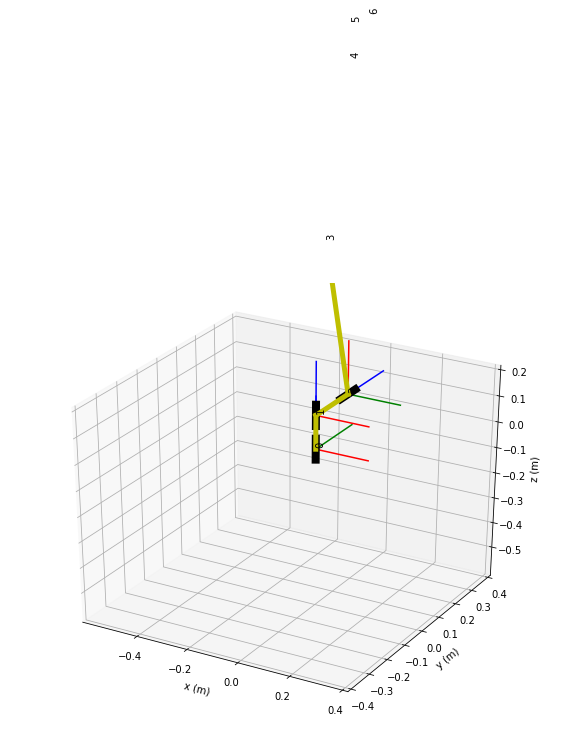

In [13]:
angle = [0, 0, 0, 0, 0, 0, 0]
geom.draw_geom(angle)

## Create dynamics

In [14]:
%time dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating the link kinetic energy of 1/6
Calculating the link kinetic energy of 2/6
Calculating the link kinetic energy of 3/6
Calculating the link kinetic energy of 4/6
Calculating the link kinetic energy of 5/6
Calculating the link kinetic energy of 6/6
Calculating joint torques...
tau of q1
tau of q2
tau of q3
tau of q4
tau of q5
tau of q6
Adding frictions and springs...
Add tendon coupling torque and motor inertia...
Calculating gregressor...
('input_vars', (q1, q2, q3, q4, q5, q6, dq1, dq2, dq3, dq4, dq5, dq6, ddq1, ddq2, ddq3, ddq4, ddq5, ddq6))
Calculating M, C and G...
Calculating base parameter...
[54 51 52 41 56 57 48 36 46 58 55 42 44 50 32 34 26 27 53 31 21 24 22 40
 16 17 11 43 23 12 14 33 10 25 15 35 47 45 30 37 59 49 29 38 20 39  5 13
 28 18 19  1  2  3  0  7  4  8  9  6]
base parameter number: 36
Creating H_b function...
Finished creating robot dynamics
CPU times: user 12min 1s, sys: 5.14 s, total: 12min 6s
Wall time: 11min 48s


In [15]:
robot_def.bary_params

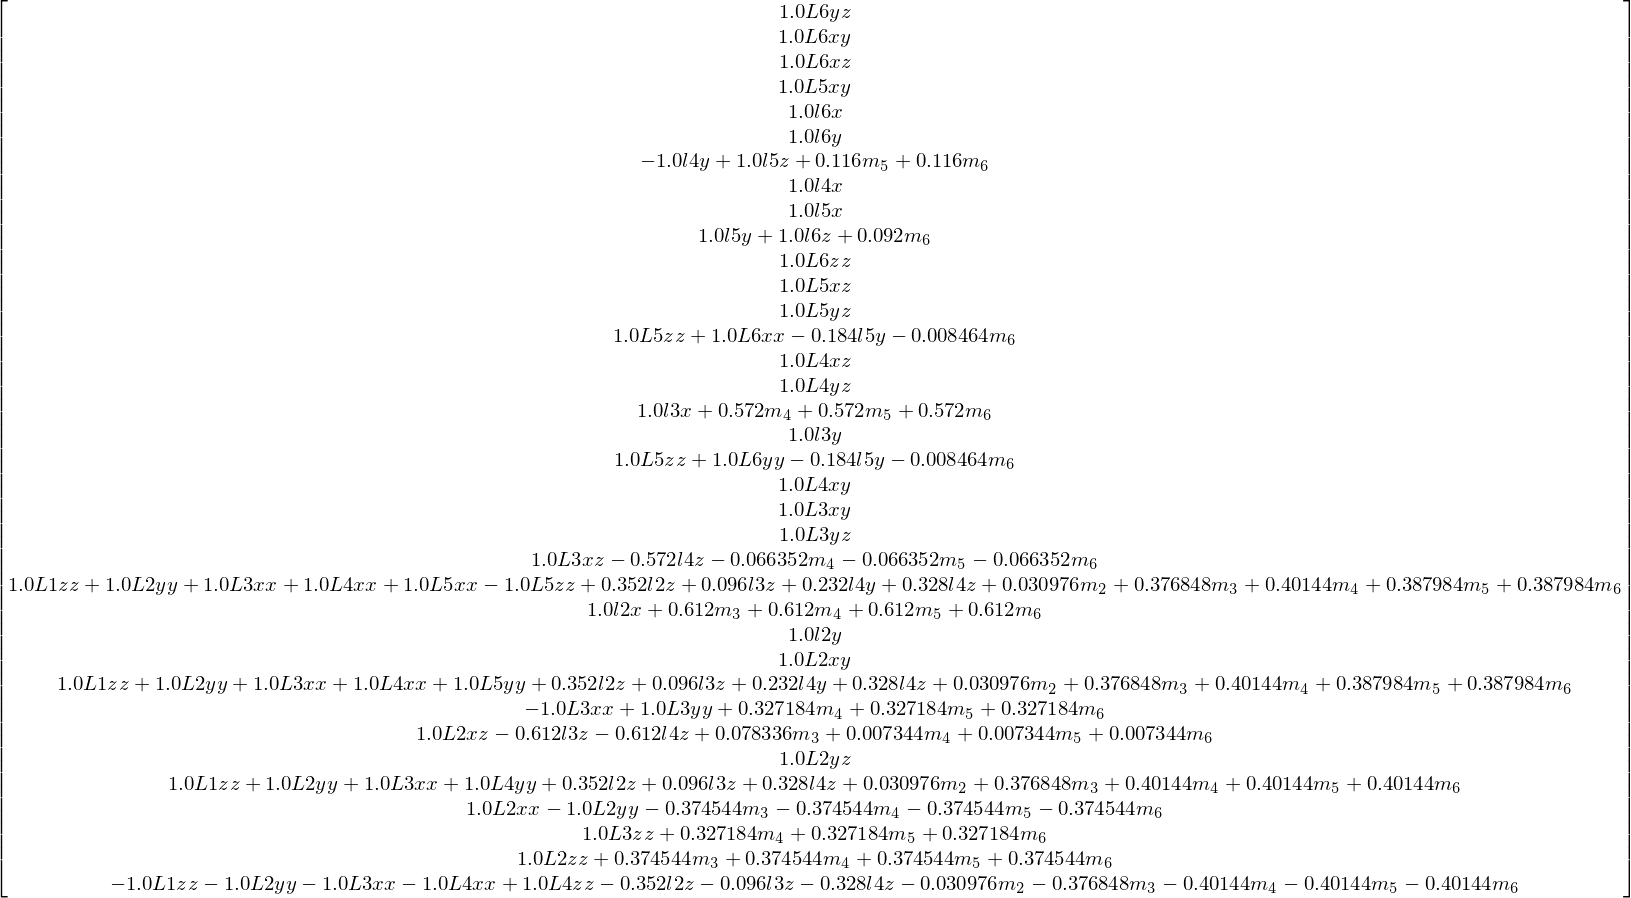

In [16]:
sympy.Matrix(dyn.base_param)

In [17]:
from data import RobotModel

# Data to be saved
robot_model = RobotModel(dyn)

# Save
save_data(model_folder, model_name, robot_model)
print('Saved {} parameters'.format(len(robot_model.base_param)))

Saved 36 parameters


---
# 3 - Excitation trajectory optimization

In [18]:
model_name = 'ur10-1'

Load Data

In [19]:
from utils import load_data
model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder, model_name)

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [20]:
trajectory_name = 'ur10'

In [21]:
from numpy import deg2rad

optimal_trajectory_folder = 'data/optimal_trajectory/'
trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'

base_freq = 0.05
fourier_order = 6

joint_constraints = []
cartesian_constraints = []


joint_constraints = [(q1, deg2rad(-180), deg2rad(180), deg2rad(-120), deg2rad(120)),
                     (q2, deg2rad(-180), deg2rad(180), deg2rad(-120), deg2rad(120)),
                     (q3, deg2rad(-180), deg2rad(180), deg2rad(-120), deg2rad(120)),
                     (q4, deg2rad(-180), deg2rad(180), deg2rad(-120), deg2rad(120)),
                     (q5, deg2rad(-180), deg2rad(180), deg2rad(-120), deg2rad(120)),
                     (q6, deg2rad(-180), deg2rad(180), deg2rad(-120), deg2rad(120))]

    
traj_optimizer = TrajOptimizer(robot_model, fourier_order, base_freq,
                               joint_constraints=joint_constraints,
                               cartesian_constraints = cartesian_constraints)
                                                                                                 
                                                                                                                     
traj_optimizer.optimize()


joint constraint number: 6
cartesian constraint number: 0
constraint number: 24
frames_constrained: []
cond: 236.930156831
cond: 236.930156831
cond: 236.930154313
cond: 236.930152913
cond: 236.930149807
cond: 236.930160165
cond: 236.930128599
cond: 236.93013184
cond: 236.930159528
cond: 236.930157118
cond: 236.930155486
cond: 236.930135397
cond: 236.930155025
cond: 236.930142975
cond: 236.930209145
cond: 236.930153992
cond: 236.930169607
cond: 236.93017014
cond: 236.930158795
cond: 236.930162415
cond: 236.930169067
cond: 236.930004673
cond: 236.93008183
cond: 236.930104425
cond: 236.930126583
cond: 236.930129876
cond: 236.930148347
cond: 236.930201056
cond: 236.930167769
cond: 236.930165307
cond: 236.930163617
cond: 236.930150007
cond: 236.930151672
cond: 236.930162277
cond: 236.930021218
cond: 236.930079782
cond: 236.930098226
cond: 236.93012235
cond: 236.930131543
cond: 236.930148809
cond: 236.930204402
cond: 236.93018468
cond: 236.930174933
cond: 236.930172667
cond: 236.930168086
co

cond: 11.1103919526
cond: 11.1103944122
cond: 11.1103948362
cond: 11.110396148
cond: 11.1103899965
cond: 11.1103903706
cond: 11.1103925063
cond: 11.110392993
cond: 11.1103927001
cond: 11.1103906995
cond: 11.1103927011
cond: 11.1103907264
cond: 11.1103923661
cond: 11.1104045045
cond: 11.1103904164
cond: 11.1103866396
cond: 11.1103896034
cond: 11.1103918374
cond: 11.1103915362
cond: 11.1103898559
cond: 11.1103880258
cond: 11.1103911954
cond: 11.1103949727
cond: 11.1103922396
cond: 11.1103928322
cond: 11.1103902332
cond: 11.1104100075
cond: 11.1103911124
cond: 11.1103856294
cond: 11.1103896212
cond: 11.1103928083
cond: 11.1103919101
cond: 11.110389871
cond: 11.1103868995
cond: 11.1103925642
cond: 11.1103942527
cond: 11.1103909994
cond: 11.1103928904
cond: 11.1103928514
cond: 11.1104026878
cond: 11.1103904052
cond: 11.1103886768
cond: 11.1103912012
cond: 11.1103920135
cond: 11.1103914137
cond: 11.1103917367
cond: 11.1103899594
cond: 11.1103935344
cond: 11.1103945485
cond: 11.1103929083
con

cond: 7.62842223007
cond: 7.62842092146
cond: 7.62842193351
cond: 7.62841994785
cond: 7.62842114355
cond: 7.62842231256
cond: 7.62842160206
cond: 7.62841986942
cond: 7.62842029628
cond: 7.62842037835
cond: 7.62842358459
cond: 7.62841643766
cond: 7.62842048476
cond: 7.62842186185
cond: 7.62842260772
cond: 7.62842093541
cond: 7.62842077463
cond: 7.62842280162
cond: 7.62842198092
cond: 7.62842281153
cond: 7.62842072594
cond: 7.6284209768
cond: 7.62842208178
cond: 7.6284224128
cond: 7.628424884
cond: 7.62842048122
cond: 7.62842118112
cond: 7.62842307593
cond: 7.628421345
cond: 7.62842080301
cond: 7.6284226867
cond: 7.62842115975
cond: 7.62842222682
cond: 7.62841989167
cond: 7.62842139995
cond: 7.62842197037
cond: 7.62842274431
cond: 7.62842617775
cond: 7.62842108908
cond: 7.62842074226
cond: 7.6284234597
cond: 7.62842149191
cond: 7.62842050389
cond: 7.628422248
cond: 7.62842141241
cond: 7.62842192097
cond: 7.62841993411
cond: 7.62842154001
cond: 7.62842202952
cond: 7.62842349432
cond: 7.62

cond: 6.54752665241
cond: 6.5475257819
cond: 6.54752594705
cond: 6.5475262123
cond: 6.54752549157
cond: 6.54753099559
cond: 6.54752576484
cond: 6.54752818497
cond: 6.5475271891
cond: 6.54752498297
cond: 6.547526546
cond: 6.5475207464
cond: 6.54752140709
cond: 6.5475257677
cond: 6.54752658576
cond: 6.54752561148
cond: 6.54752657229
cond: 6.5475261149
cond: 6.54752908852
cond: 6.54752625822
cond: 6.54752822734
cond: 6.54752756366
cond: 6.54752507486
cond: 6.54752633817
cond: 6.54751981897
cond: 6.54752277768
cond: 6.54752588167
cond: 6.54752601818
cond: 6.5475257147
cond: 6.54752695906
cond: 6.54752647742
cond: 6.54752896235
cond: 6.54752601691
cond: 6.54752838618
cond: 6.54752730325
cond: 6.54752557743
cond: 6.5475264951
cond: 6.54752075042
cond: 6.54752420446
cond: 6.5475265559
cond: 6.54752589109
cond: 6.54752627819
cond: 6.54752671312
cond: 6.54752742333
cond: 6.54752788606
cond: 6.54752933595
cond: 6.54752769853
cond: 6.54752660356
cond: 6.54752589006
cond: 6.54752581459
cond: 6.547

cond: 5.94031479714
cond: 5.94030708207
cond: 5.94031080539
cond: 5.94031187719
cond: 5.94031207375
cond: 5.94031388148
cond: 5.94031181628
cond: 5.94031326676
cond: 5.94031336621
cond: 5.94031404012
cond: 5.94031318018
cond: 5.94031202805
cond: 5.94031386763
cond: 5.94031238219
cond: 5.94031060556
cond: 5.94031124038
cond: 5.94031113204
cond: 5.94031204087
cond: 5.9403143086
cond: 5.94031257693
cond: 5.94031268408
cond: 5.94031058214
cond: 5.94031417604
cond: 5.94031444373
cond: 5.94031217445
cond: 5.94031297689
cond: 5.94031347951
cond: 5.94030974125
cond: 5.94031187107
cond: 5.94031182186
cond: 5.9403125284
cond: 5.94031413445
cond: 5.94031224804
cond: 5.94031129347
cond: 5.94031263572
cond: 5.94031450745
cond: 5.94031411877
cond: 5.94031190174
cond: 5.94031318887
cond: 5.94031340787
cond: 5.94031184072
cond: 5.9403137212
cond: 5.94031337772
cond: 5.94031282223
cond: 5.94031347073
cond: 5.94031284787
cond: 5.94031139817
cond: 5.94031174785
cond: 5.94031236846
cond: 5.9403129378
cond

cond: 5.39232348519
cond: 5.39232219003
cond: 5.39232636605
cond: 5.39232442688
cond: 5.39232402541
cond: 5.39232537507
cond: 5.39232464954
cond: 5.3923254611
cond: 5.39232184002
cond: 5.39232493885
cond: 5.39232534957
cond: 5.39232539729
cond: 5.3923240828
cond: 5.39232378895
cond: 5.39232155848
cond: 5.39232649104
cond: 5.3923254741
cond: 5.39232397353
cond: 5.3923245054
cond: 5.3923252102
cond: 5.39232501287
cond: 5.39232367377
cond: 5.39232587668
cond: 5.392325111
cond: 5.39232484081
cond: 5.3923248352
cond: 5.39232376001
cond: 5.3923226713
cond: 5.39232510421
cond: 5.39232477087
cond: 5.39232457206
cond: 5.39232526141
cond: 5.39232488578
cond: 5.39232534873
cond: 5.39232729039
cond: 5.39232303873
cond: 5.39232424731
cond: 5.39232460734
cond: 5.39232433347
cond: 5.3923255529
cond: 5.39232520496
cond: 5.39232482661
cond: 5.39232474716
cond: 5.39232489749
cond: 5.39232457521
cond: 5.39232489507
cond: 5.39232437561
cond: 5.39232553207
cond: 5.39232512539
cond: 5.39232411895
cond: 5.39

cond: 5.05737595398
cond: 5.05737579915
cond: 5.0573823751
cond: 5.05737927598
cond: 5.05737797912
cond: 5.05737806288
cond: 5.05737764712
cond: 5.05737801383
cond: 5.05738179536
cond: 5.05737710346
cond: 5.05737722065
cond: 5.05737560827
cond: 5.0573759624
cond: 5.05737638588
cond: 5.0573763011
cond: 5.05738135933
cond: 5.05737956964
cond: 5.05737822632
cond: 5.05737774259
cond: 5.05737783892
cond: 5.05737783648
cond: 5.05738180282
cond: 5.0573776892
cond: 5.05737731408
cond: 5.05737560879
cond: 5.05737624119
cond: 5.05737645713
cond: 5.05737774228
cond: 5.0573767955
cond: 5.05737695429
cond: 5.05737894932
cond: 5.05737809205
cond: 5.05737723707
cond: 5.05737840224
cond: 5.05737676805
cond: 5.05737750602
cond: 5.05737909093
cond: 5.05737804414
cond: 5.05737751685
cond: 5.05737838172
cond: 5.05737781866
cond: 5.05737673767
cond: 5.05737792769
cond: 5.05737744632
cond: 5.05737745488
cond: 5.0573777279
cond: 5.05737743807
cond: 5.05737738901
cond: 5.05737757023
cond: 5.05737752177
cond: 

cond: 4.76862556087
cond: 4.76862687519
cond: 4.76862698908
cond: 4.76862697743
cond: 4.76862744638
cond: 4.76862752368
cond: 4.76862607348
cond: 4.76862425805
cond: 4.76862666842
cond: 4.7686276624
cond: 4.76862830114
cond: 4.76862721002
cond: 4.76862757901
cond: 4.76862634583
cond: 4.76862657693
cond: 4.76862702393
cond: 4.76862695017
cond: 4.76862729154
cond: 4.76862753926
cond: 4.76862591426
cond: 4.76862775847
cond: 4.76862817638
cond: 4.7686272373
cond: 4.76862791218
cond: 4.76862676027
cond: 4.76862679897
cond: 4.76862812413
cond: 4.76862631594
cond: 4.7686263016
cond: 4.76862657109
cond: 4.76862687494
cond: 4.76862780704
cond: 4.76862774936
cond: 4.7686277418
cond: 4.76862770916
cond: 4.76862737829
cond: 4.76862744496
cond: 4.76862735795
cond: 4.76862753397
cond: 4.76862698489
cond: 4.76862840111
cond: 4.76862691215
cond: 4.76862644089
cond: 4.76862746039
cond: 4.76862745234
cond: 11.3108400513
cond: 5.2898451928
cond: 4.76519651985
cond: 4.75431085437
cond: 4.75431085437
cond:

cond: 4.60205029896
cond: 4.60204905343
cond: 4.60205263922
cond: 4.60205252908
cond: 4.60205007786
cond: 4.6020501456
cond: 4.6020501114
cond: 4.60204996605
cond: 4.60205322933
cond: 4.60204980386
cond: 4.60204866224
cond: 4.60204869033
cond: 4.60204795411
cond: 4.60205030293
cond: 4.60205056894
cond: 4.60204932844
cond: 4.60204943224
cond: 4.60205091446
cond: 4.60205025608
cond: 4.60204953976
cond: 4.6020505542
cond: 4.60204958859
cond: 4.60205085136
cond: 4.60205161789
cond: 4.60205005246
cond: 4.6020499461
cond: 4.60205048074
cond: 4.60205029374
cond: 4.6020495217
cond: 4.6020505171
cond: 4.60205022936
cond: 4.60204973392
cond: 4.60205021523
cond: 4.60205020829
cond: 4.60205049169
cond: 4.60205054605
cond: 4.60204983278
cond: 4.60204963142
cond: 4.60204997028
cond: 4.60205019087
cond: 7.89024669226
cond: 4.87108773654
cond: 4.62826274422
cond: 4.59594540427
cond: 4.59594540427
cond: 4.59594449365
cond: 4.59594541692
cond: 4.59594589084
cond: 4.59594570921
cond: 4.59594485854
cond: 

cond: 4.49851054032
cond: 4.49851091903
cond: 4.49851041221
cond: 4.49851126781
cond: 4.49851079374
cond: 4.49850966238
cond: 4.49851087556
cond: 4.49851149257
cond: 4.49851357669
cond: 4.4985101319
cond: 4.49851111266
cond: 4.49851076296
cond: 4.49851033701
cond: 4.49851178871
cond: 4.49851108431
cond: 4.49851092097
cond: 4.49851068685
cond: 4.49851095023
cond: 4.49851125317
cond: 4.49851088629
cond: 4.49851030059
cond: 4.4985106072
cond: 4.49851059569
cond: 4.49851036554
cond: 4.49851057309
cond: 4.49851068377
cond: 4.4985106413
cond: 4.49851110964
cond: 4.49851005956
cond: 4.49851056029
cond: 4.49851106712
cond: 4.49851079708
cond: 4.49851040664
cond: 5.6858316698
cond: 4.6676625777
cond: 4.49912335729
cond: 4.47953953505
cond: 4.47953953505
cond: 4.4795401173
cond: 4.47953943226
cond: 4.47953964404
cond: 4.47953984185
cond: 4.47953909859
cond: 4.4795392363
cond: 4.47953949245
cond: 4.47953958343
cond: 4.47953950181
cond: 4.47953949193
cond: 4.47953912011
cond: 4.47954018866
cond: 4

cond: 4.40455833501
cond: 4.40455909425
cond: 4.40455984305
cond: 4.40455912075
cond: 4.40455809972
cond: 4.40455882122
cond: 4.40455753366
cond: 4.40455891955
cond: 4.40455971995
cond: 4.40455818229
cond: 4.40455842365
cond: 4.40455944269
cond: 4.40455880933
cond: 4.40455880401
cond: 4.40455951156
cond: 4.4045588088
cond: 4.40455837865
cond: 4.40455874345
cond: 4.404558629
cond: 4.40455745414
cond: 4.40455813769
cond: 4.40455863842
cond: 4.40455871048
cond: 4.40455878657
cond: 4.40455870194
Condition number: 4.40455859275
x: [ 0.17143449 -0.04227961 -0.16502577 -0.10820623 -0.67108869  1.28951025
  0.6885175   0.11435139  0.18959138 -0.27791171  0.44219426 -0.07244895
  0.26957942 -0.88147945  0.39916494 -0.19787112 -0.3205953   0.18535761
  0.57266366 -0.14224928  0.04428058  0.32114285 -0.13383453 -0.26746136
 -0.01602835 -0.19700101  0.18175058  0.15744221  0.09157645  0.13880902
 -0.18925401 -0.02337196  0.14273857  0.15291274  0.99955987  0.30727488
 -0.14483239  0.19974353 -0.20

In [22]:
reg_norm_mat = traj_optimizer.calc_normalize_mat()

## Plot optimal excitation trajectory

In [23]:
traj_optimizer.calc_frame_traj()

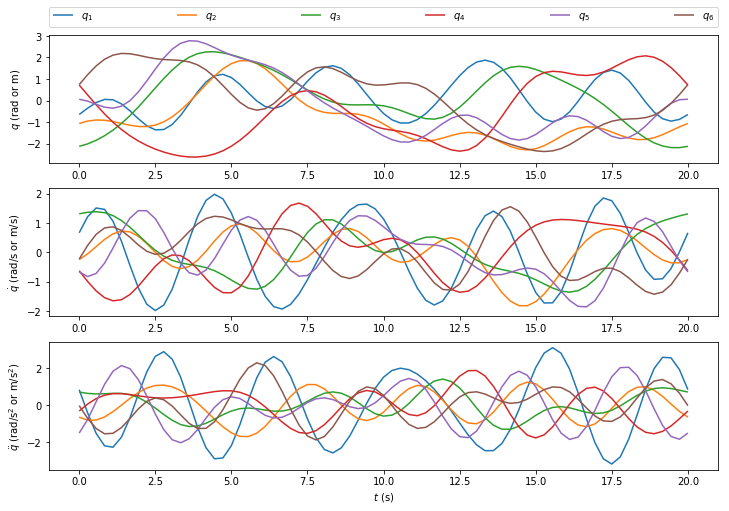

<Figure size 864x576 with 0 Axes>

In [24]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj,traj_optimizer.frame_traj,
                           traj_optimizer.const_frame_ind, robot_model.coordinates)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

traj_plotter.plot_frame_traj(True)

## Save trajectory for later use

In [25]:
dof_order_bf_x_norm = (traj_optimizer.fourier_traj.dof, fourier_order,
                       base_freq, traj_optimizer.x_result, reg_norm_mat)
save_data(trajectory_folder, trajectory_name, dof_order_bf_x_norm)

freq = 50
tf = 65 # including 5 seconds' prestable time
traj_optimizer.make_traj_csv(trajectory_folder, trajectory_name, freq, tf)

In [27]:
from IPython.display import HTML, display
import tabulate

table = []
table.append(["joint", 'qo'] +
             ["a"+str(i+1) for i in range(fourier_order)] +
             ["b"+str(i+1) for i in range(fourier_order)])
for i in range(traj_optimizer.fourier_traj.dof):
    line = []
    line.append(robot_model.coordinates[i])
    line += np.round(traj_optimizer.x_result[i*(1 + fourier_order*2): (i+1)*(1 + fourier_order*2)], 4).tolist()
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

joint,qo,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
q1,0.1714,-0.0423,-0.165,-0.1082,-0.6711,1.2895,0.6885,0.1144,0.1896,-0.2779,0.4422,-0.0724,0.2696
q2,-0.8815,0.3992,-0.1979,-0.3206,0.1854,0.5727,-0.1422,0.0443,0.3211,-0.1338,-0.2675,-0.016,-0.197
q3,0.1818,0.1574,0.0916,0.1388,-0.1893,-0.0234,0.1427,0.1529,0.9996,0.3073,-0.1448,0.1997,-0.2026
q4,-0.5306,-0.3062,-1.0029,0.2413,-0.0354,-0.6051,0.0828,-0.2223,-0.1301,-0.2589,-0.1642,-0.0496,0.1952
q5,-0.1871,0.5251,0.158,-0.1851,-0.1358,-0.0446,-0.4594,-0.1356,0.4945,-0.036,0.0947,-0.5967,-0.4893
q6,0.1203,0.4825,0.3134,0.2467,0.0369,0.0551,0.5532,-0.0242,-0.5866,0.2614,0.3356,-0.3271,0.107


---
# Data processing

In [29]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

## Load data

### Load robot model

In [30]:
model_name = 'ur10-1'
training_trajectory_name = 'ur10'


model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder,model_name)


trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
dof, fourier_order, base_freq, traj_optimizer_result, reg_norm_mat = load_data(trajectory_folder,
                                                                               training_trajectory_name)
print("dof: {}".format(dof))
print("Fourier order: {}".format(fourier_order))
print("Base frequency: {}".format(base_freq))

dof: 6
Fourier order: 6
Base frequency: 0.05


In [31]:
robot_model.coordinates

### Load traning data set

In [32]:
# training_trajectory_name = 'one'

results_folder = 'data/' + model_name +'/measured_trajectory/'
training_results_data_file = results_folder + training_trajectory_name + '_results.csv'

trajectory_sampling_rate = 50
t_train, q_raw_train, dq_raw_train, tau_raw_train = load_trajectory_data(training_results_data_file,
                                                                   trajectory_sampling_rate)

(<type 'numpy.ndarray'>, (2990, 18))


### Load test data set

In [33]:
test_trajectory_name = 'ur10_test'

results_folder = 'data/' + model_name +'/measured_trajectory/'
test_results_data_file = results_folder + test_trajectory_name + '_results.csv'

trajectory_sampling_rate = 50
t_test, q_raw_test, dq_raw_test, tau_raw_test = load_trajectory_data(test_results_data_file,
                                                                trajectory_sampling_rate)

(<type 'numpy.ndarray'>, (2990, 18))


## Calculate filter cut-off frequency

In [34]:
# times of the highest frequency in the Fourier series
fc_mult = 10.0

fc = base_freq * fourier_order * fc_mult
print("Cut frequency: {}".format(fc))

Cut frequency: 3.0


## Differentiation and filtering

### Traning data

q_raw shape: (2990, 6)
plot shape: 460


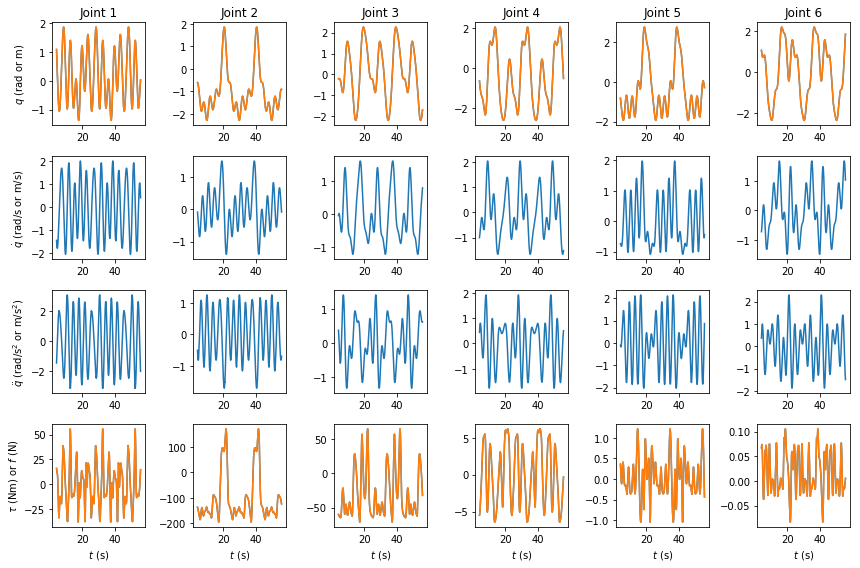

In [35]:
t_cut_train, q_f_train, dq_f_train, ddq_f_train, tau_f_train, q_raw_cut_train, tau_raw_cut_train =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_train, q_raw_train, dq_raw_train, tau_raw_train, fc, fc, fc, fc)
plot_trajectory_data(t_cut_train, q_raw_cut_train, q_f_train, dq_f_train, ddq_f_train,
                     tau_raw_cut_train, tau_f_train)

### Test data

q_raw shape: (2990, 6)
plot shape: 460


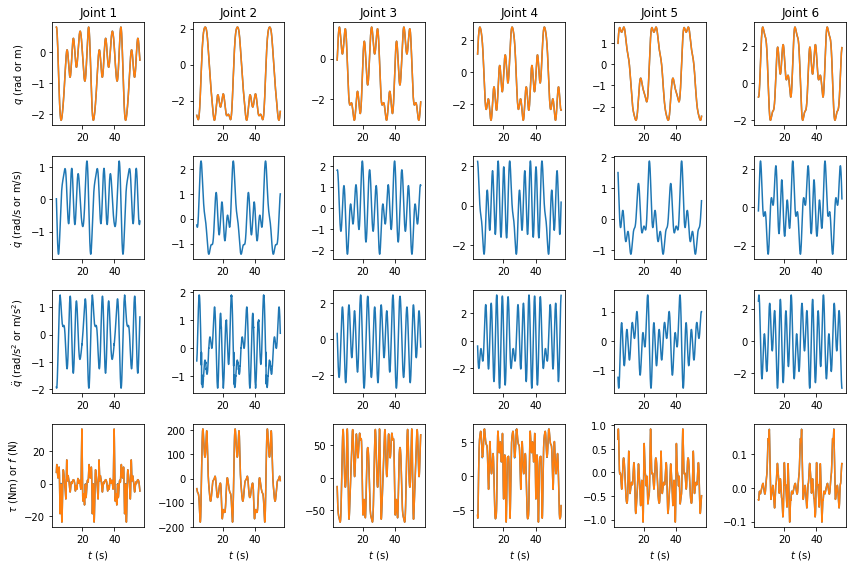

In [36]:
t_cut_test, q_f_test, dq_f_test, ddq_f_test,tau_f_test, q_raw_cut_test, tau_raw_cut_test =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_test, q_raw_test, dq_raw_test, tau_raw_test, fc, fc, fc, fc)
plot_trajectory_data(t_cut_test, q_raw_cut_test, q_f_test, dq_f_test, ddq_f_test,
                     tau_raw_cut_test, tau_f_test)

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [37]:
base_param_num = robot_model.base_num
H_b_func = robot_model.H_b_func
W_b_train, tau_s_train = gen_regressor(base_param_num, H_b_func, q_f_train,
                                       dq_f_train, ddq_f_train, tau_f_train)

In [38]:
W_b_train.shape, tau_s_train.shape
#print np.linalg.cond(W_b_train)

In [39]:
xb_ols = np.linalg.lstsq(W_b_train, tau_s_train)[0]

/home/kiwi/anaconda2/envs/wangyan/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


In [40]:
#sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_ols))

from IPython.display import HTML, display
import tabulate

table = [["Base Parameter", "Value"]]

for i in range(robot_model.base_num):
    param_str = str(sympy.Matrix(robot_model.base_param)[i])
    max_disp_len = 50
    line = [param_str if len(param_str) <= max_disp_len 
            else param_str[:max_disp_len] + '...', xb_ols[i]]
    #['%.7s ...'%b if len(str(b)) > 7 else str(b)
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

Base Parameter,Value
1.0*L6yz,-0.00783551688471395
1.0*L6xy,-0.017944803556512127
1.0*L6xz,-0.027779340045856107
1.0*L5xy,-0.015467709838000738
1.0*l6x,0.01945747490304416
1.0*l6y,0.012306291516449444
-1.0*l4y + 1.0*l5z + 0.116*m5 + 0.116*m6,-0.5843215763517456
1.0*l4x,-0.012633629297075784
1.0*l5x,0.0120330131416968
1.0*l5y + 1.0*l6z + 0.092*m6,-0.06003551759761618


## Compare measured torque and predicted torque on the training set

### Generate predicted torque

In [41]:
tau_p_train = np.zeros(tau_f_train.shape)
tau_ps_train = W_b_train.dot(xb_ols)
for i in range(dof):
    tau_p_train[:, i] = tau_ps_train[i::dof]
    

### Evaluate regression

In [42]:
var_regression_error_ols = np.linalg.norm(tau_ps_train - tau_s_train) / \
                        (tau_ps_train.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols *
                                 np.linalg.inv(W_b_train.transpose().dot(W_b_train))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.005565132458876687
standard deviation of xb using OLS:
[0.00028391 0.00034761 0.0002917  0.00036917 0.00016427 0.0001304
 0.0001603  0.00016002 0.00018328 0.00018503 0.00052149 0.00046351
 0.00041806 0.00069466 0.00075293 0.0006263  0.00020467 0.0001895
 0.00077283 0.00051036 0.00061895 0.00084726 0.00071175 0.00155929
 0.00024175 0.00038378 0.00086841 0.00129274 0.00118165 0.00171705
 0.0009555  0.00130743 0.0018944  0.00153895 0.00272417 0.00203783]
percentage of standard deviation of xb using OLS: 
[3.62334536e-02 1.93712478e-02 1.05007000e-02 2.38668805e-02
 8.44268439e-03 1.05959301e-02 2.74337576e-04 1.26663213e-02
 1.52310583e-02 3.08206290e-03 1.88279031e-02 8.62894098e-03
 1.48791093e-02 4.12978443e-03 7.13623674e-03 1.01642164e-02
 3.03185900e-05 4.41382021e-03 3.69912940e-03 7.71247601e-02
 7.77683991e-03 6.46360204e-02 1.42607669e-03 2.31122866e-04
 2.03310742e-05 3.57700894e-02 1.61299986e-02 1.86204071e-04
 3.81097494e-04 1.441489

### Plot measured torque and predicted torque

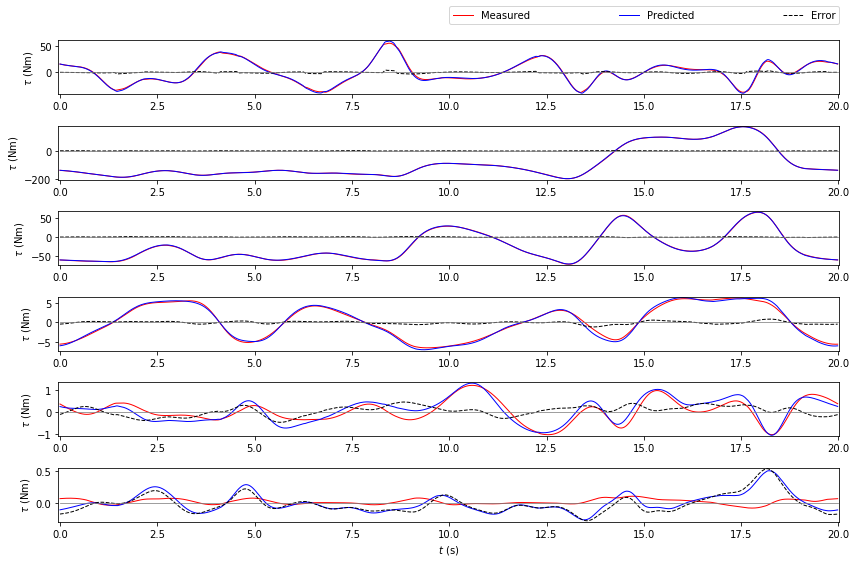

In [43]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_train[:plot_data_num, :], robot_def.coordinates_joint_type)

## Compare measured torque and predicted torque on the test set

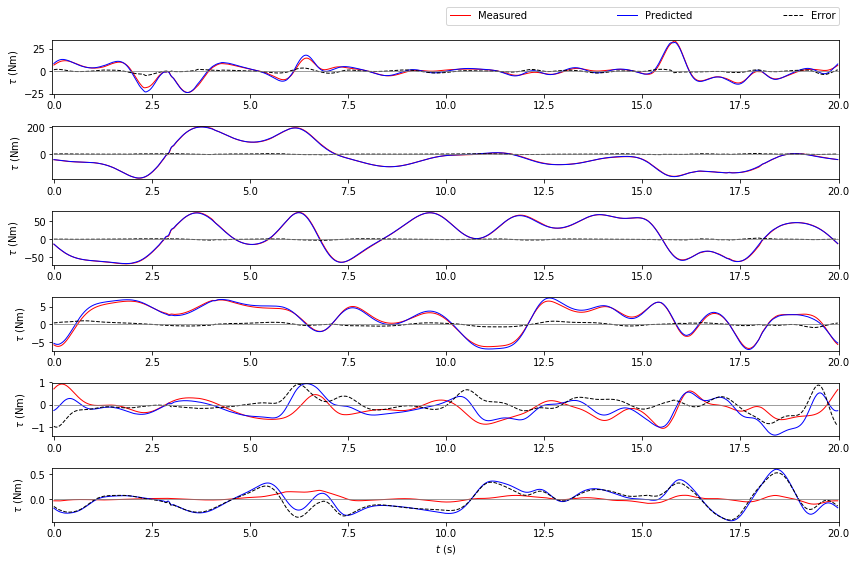

In [44]:
W_b_test, tau_s_test = gen_regressor(base_param_num, H_b_func, q_f_test,
                                       dq_f_test, ddq_f_test, tau_f_test)

tau_p_test = np.zeros(tau_f_test.shape)
tau_ps_test = W_b_test.dot(xb_ols)
for i in range(dof):
    tau_p_test[:, i] = tau_ps_test[i::dof]

plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_test[:plot_data_num, :], robot_def.coordinates_joint_type)

## Weighted Least Square (WLS)

### Training data set

In [45]:
# weight = np.sqrt(np.linalg.norm(tau_f - tau_p, axis=0)/(tau_f.shape[0] - base_param_num))
weight = np.max(tau_f_train, axis=0) - np.min(tau_f_train, axis=0)
weight
weight[1] /= 1
weight[2] /= 1
weight[3] /= 1
weight

array([9.38484256e+01, 3.65728839e+02, 1.36262354e+02, 1.26402403e+01,
       2.26687287e+00, 1.89027225e-01])

In [46]:
W_b_train.shape, tau_s_train.shape

In [47]:
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_train.shape[0]/weight.shape[0])

In [48]:
weights.shape

In [49]:
W_b_wls_train = np.multiply(W_b_train, np.asmatrix(weights).transpose())
tau_s_wls_train = np.multiply(tau_s_train, weights)

In [50]:
xb_wls = np.linalg.lstsq(W_b_wls_train, tau_s_wls_train)[0]

/home/kiwi/anaconda2/envs/wangyan/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


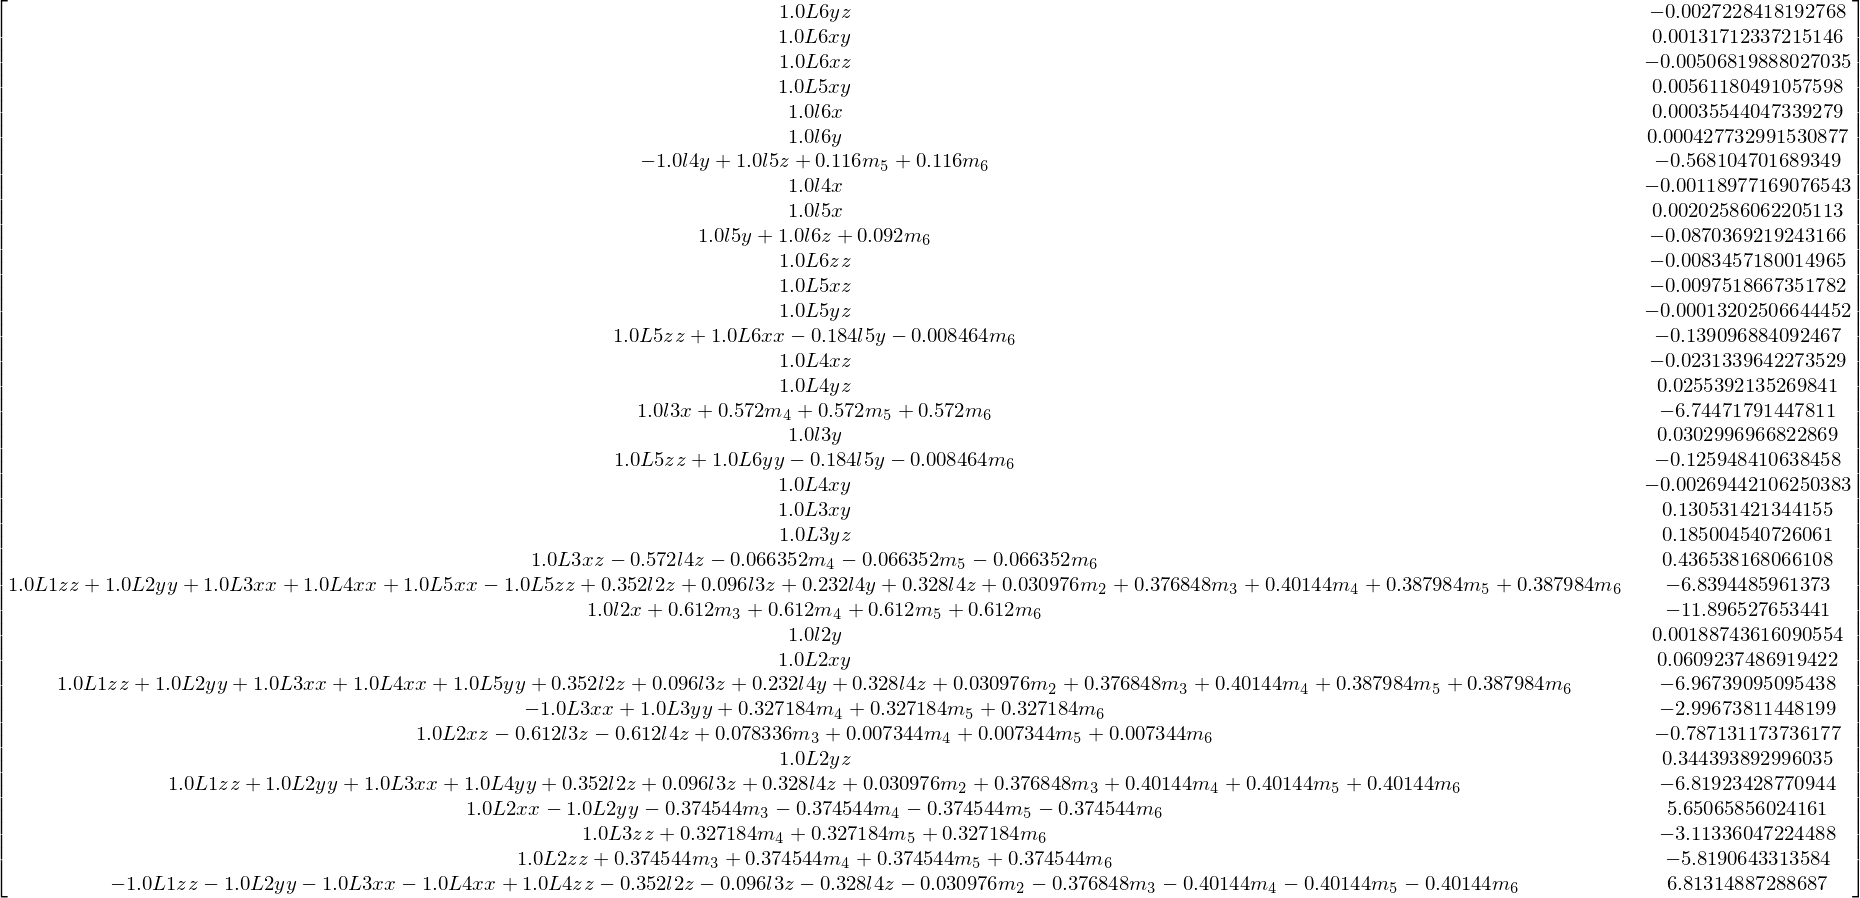

In [51]:
#np.set_printoptions(precision=2)
sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_wls))

In [52]:
tau_p_wls_train = np.zeros(tau_f_train.shape)
tau_ps_wls_train = W_b_train.dot(xb_wls)
for i in range(dof):
    tau_p_wls_train[:, i] = tau_ps_wls_train[i::dof]

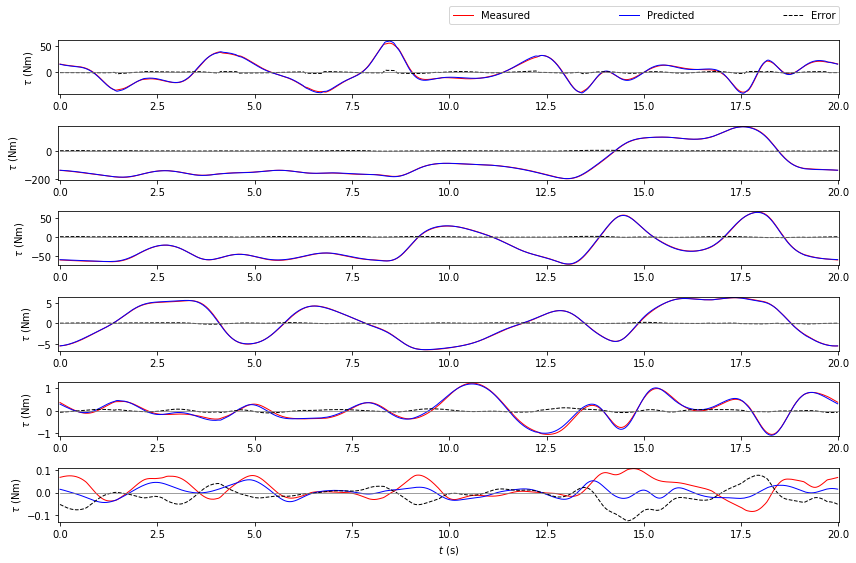

In [53]:
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_wls_train[:plot_data_num, :], robot_def.coordinates_joint_type)

In [54]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_wls_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.05734835, 0.0113076 , 0.01762461, 0.02006448, 0.09806725,
       0.86549323])

In [55]:
robot_model.bary_param

In [56]:
robot_def.d_coordinates[0] != robot_def.dq_for_frame[1]

False

In [57]:
robot_model.coordinates[1].name[1:]

'2'

### Test data set

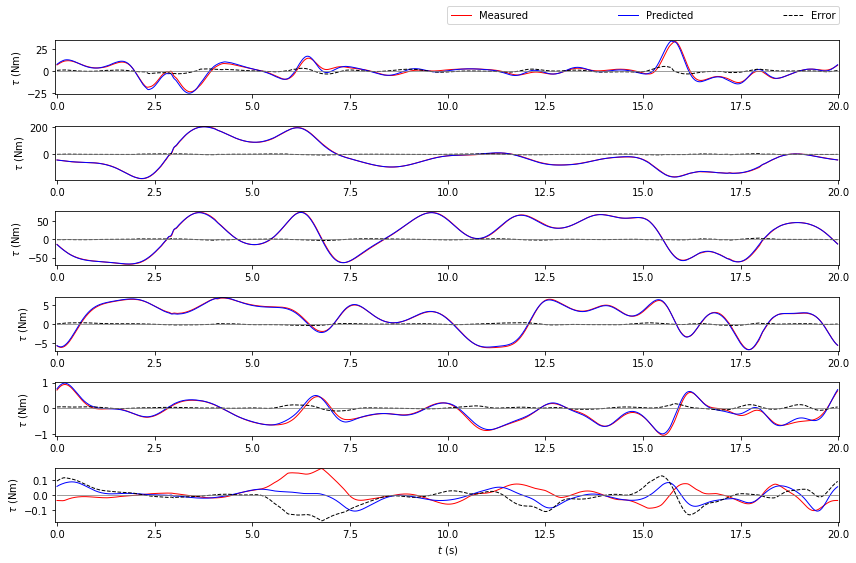

In [58]:
weight = np.max(tau_f_test, axis=0) - np.min(tau_f_test, axis=0)
weight
weight[1] /= 1
weight[2] /= 1
weight[3] /= 1
weight
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_test.shape[0]/weight.shape[0])

W_b_wls_test = np.multiply(W_b_test, np.asmatrix(weights).transpose())
tau_s_wls_test = np.multiply(tau_s_test, weights)

tau_p_wls_test = np.zeros(tau_f_test.shape)
tau_ps_wls_test = W_b_test.dot(xb_wls)
for i in range(dof):
    tau_p_wls_test[:, i] = tau_ps_wls_test[i::dof]

plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_wls_test[:plot_data_num, :], robot_def.coordinates_joint_type)

In [59]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_wls_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.18436654, 0.01929428, 0.0228826 , 0.04170818, 0.12745559,
       1.11239204])

## Convex optimization

### Generate regressor matrix for barycentric parameters

In [60]:
from identification.sdp_opt import SDPOpt

bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_train, tau_s_train = gen_regressor(bary_param_num, H_func,
                                     q_f_train, dq_f_train, ddq_f_train, tau_f_train)


weight = np.max(tau_f_train, axis=0) - np.min(tau_f_train, axis=0)
weight
weight[1] /= 1
weight[2] /= 1
weight[3] /= 1
print("weight: ")
print(weight)

print("W_train.shape, tau_s_train.shape: ")
print(W_train.shape, tau_s_train.shape)

# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_train.shape[0]/weight.shape[0])

weight: 
[9.38484256e+01 3.65728839e+02 1.36262354e+02 1.26402403e+01
 2.26687287e+00 1.89027225e-01]
W_train.shape, tau_s_train.shape: 
((15540, 60), (15540,))


In [61]:
W_w_train = np.multiply(W_train, np.asmatrix(weights).transpose())
tau_w_s_train = np.multiply(tau_s_train, weights)

In [62]:
len(robot_model.std_param)

| min mass | max mass | min $r_x$ | max $r_x$ | min $r_y$ | max $r_y$ | min $r_z$ | max $r_z$ | max $F_c$ | max $F_v$ | max $F_o$ |
|----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|--------------|-----------|

In [63]:
sdp_constraints = []
spring_constraints = []

sdp_constraints = [(0.5, 10, -0.2, 0.2, -0.2, 0.2, -0.2, 0.2, 0.5, 0.5, 0.5),
                  (0.5, 10, -0.7, 0.7, -0.7, 0.7, -0.7, 0.7, 0.5, 0.5, 0.5),
                  (0.5, 10, -0.6, 0.6, -0.6, 0.6, -0.6, 0.6, 0.1, 0.5, 0.5),
                  (0.5, 10, -0.2, 0.2, -0.2, 0.2, -0.2, 0.2, 0.1, 0.1, 0.1),
                  (0.5, 10, -0.2, 0.2, -0.2, 0.2, -0.2, 0.2, 0.1, 0.1, 0.1),
                  (0.5, 10, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1, 0.1, 0.1, 0.1)]


In [64]:
sdp_opt_std = SDPOpt(W_w_train, tau_w_s_train, robot_model,
                     sdp_constraints, spring_constraints)
# sdp_opt_std = SDPOpt(W, tau_s, robot_model, sdp_constraints)
%time sdp_opt_std.solve()

Regressor shape: (15540, 60)
Regressand shape: (15540,)
Creating variables...
Creating optimization objective...
Creating constraints...
Solving problem...
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 487096, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 15000, normalize = 1, scale = 1.00
Variables n = 61, constraints m = 15717
Cones:	linear vars: 49
	soc vars: 15542, soc blks: 1
	sd vars: 126, sd blks: 6
Setup time: 2.87e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.96e+01  1.30e+02  1.00e+00 -2.53e+03  6.28e+02  2.22e-12  7.78e-02 
  

## Compare measured torque and predicted torque on training set

### Generate predicted torque

In [65]:
tau_p_sdp_train = np.zeros(tau_f_train.shape)
tau_ps_sdp_train = W_train.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_train[:, i] = tau_ps_sdp_train[i::dof]

In [66]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_sdp_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([1.6072819 , 0.88877238, 0.45911305, 0.48822082, 0.71320975,
       0.86517548])

### Plot measured torque and predicted torque

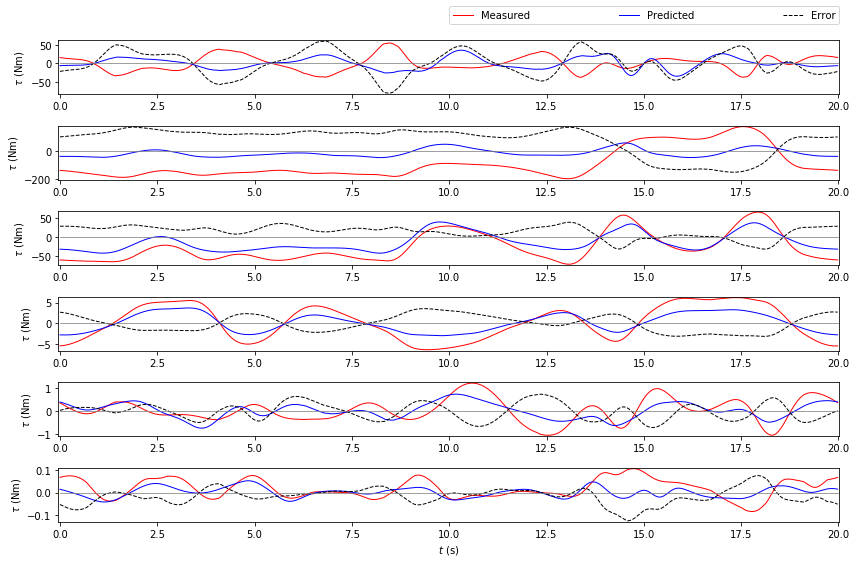

In [67]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num] - t_cut_train[0],
                   tau_f_train[:plot_data_num, :],
                   tau_p_sdp_train[:plot_data_num, :],
                   robot_def.coordinates_joint_type)

## Compare measured torque and predicted torque on test set

In [68]:
bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_test, tau_s_test = gen_regressor(bary_param_num, H_func,
                                   q_f_test, dq_f_test, ddq_f_test, tau_f_test)

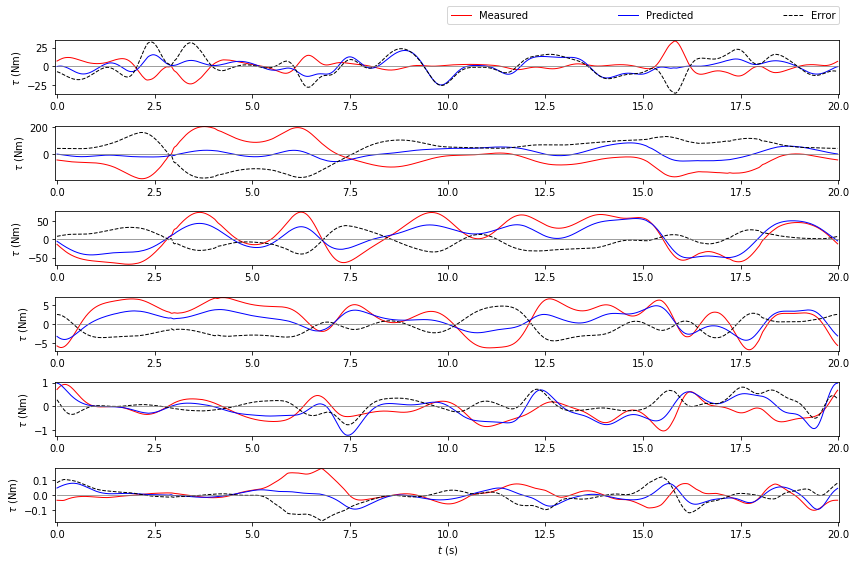

In [69]:
tau_p_sdp_test = np.zeros(tau_f_test.shape)
tau_ps_sdp_test = W_test.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_test[:, i] = tau_ps_sdp_test[i::dof]
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num] - t_cut_test[0],
                   tau_f_test[:plot_data_num, :],
                   tau_p_sdp_test[:plot_data_num, :],
                   robot_def.coordinates_joint_type)

In [70]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_sdp_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([1.68221627, 0.98776082, 0.43066393, 0.5758733 , 0.73136166,
       1.06205067])

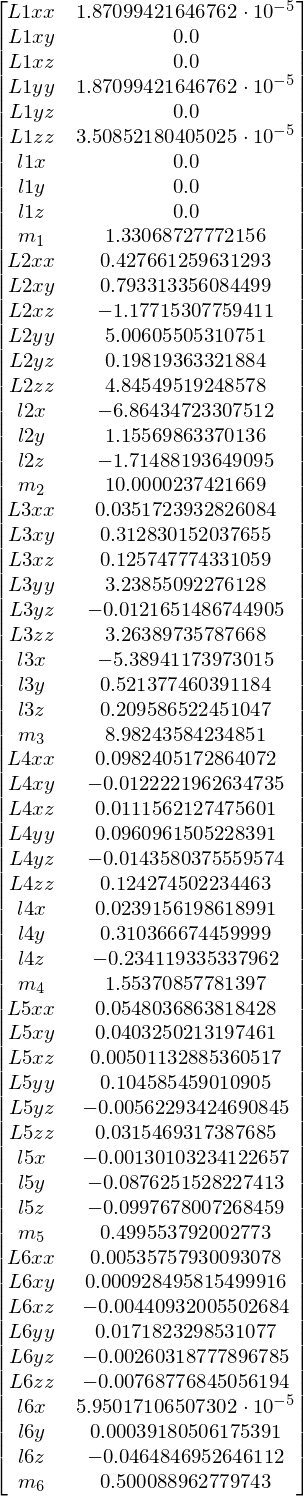

In [71]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.bary_param), sympy.Matrix(sdp_opt_std.x_result))

In [72]:
from identification import barycentric2standard_params

In [73]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_model)

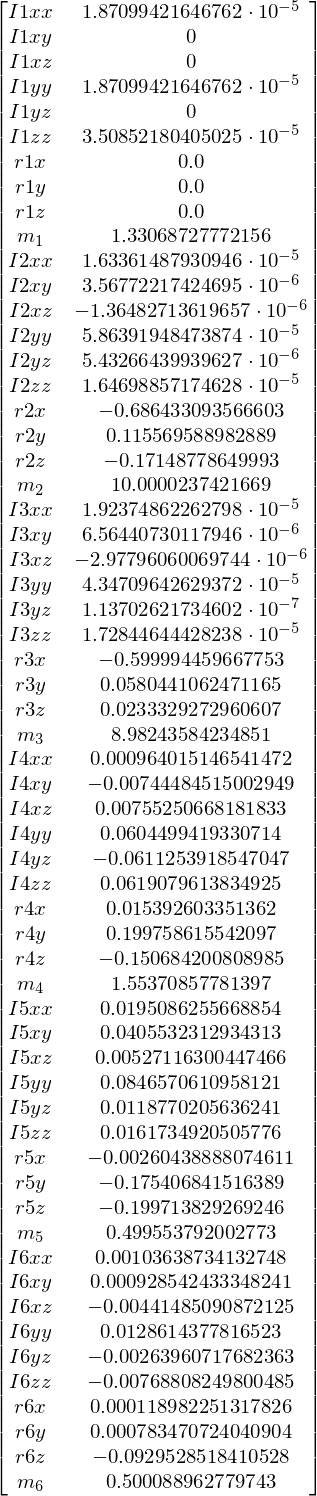

In [74]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.std_param), sympy.Matrix(x_std))